In [1]:
import SfM_opencv as sfmcv2
import utils as ut 
import SfM_numpy as sfmnp

import matplotlib.pyplot as plt 
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D

import cv2 
import numpy as np 

%load_ext autoreload
%autoreload 2

# 1. Epipolar Geometry

## 1.0. Reading a pair of images, and comparing SIFT matches

<IPython.core.display.Javascript object>


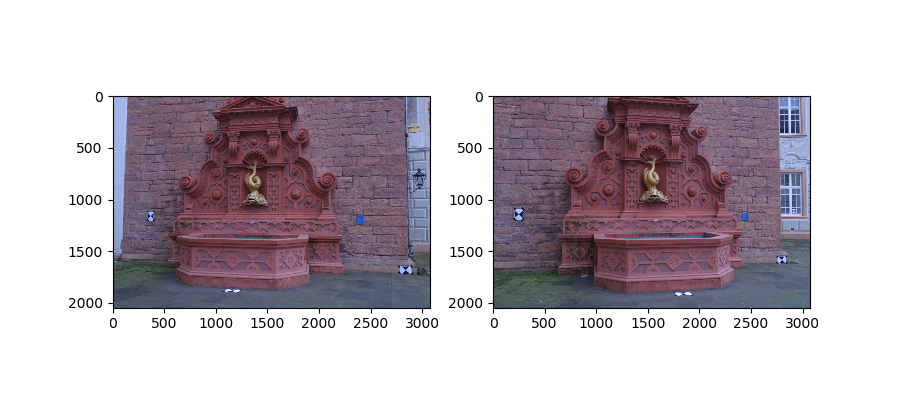

In [2]:
#Reading two images for reference
img1 = cv2.imread('./data/fountain-P11/images/0004.jpg')
img2 = cv2.imread('./data/fountain-P11/images/0006.jpg')

#Converting from BGR to RGB format
img1 = img1[:,:,::-1]
img2 = img2[:,:,::-1]

#NOTE: you can adjust appropriate figure size according to the size of your screen
fig,ax=plt.subplots(ncols=2,figsize=(9,4)) 
ax[0].imshow(img1)
ax[1].imshow(img2)

In [3]:
#Getting SIFT/SURF features for image matching (this might take a while)
kp1,desc1,kp2,desc2,matches=sfmcv2.GetImageMatches(img1,img2)

#Aligning two keypoint vectors
img1pts,img2pts=sfmcv2.GetAlignedMatches(kp1,desc1,kp2,desc2,matches)

## 1.1. Fundamental Matrix Computation

### 1.1.1. Eight Point Algorithm

In [4]:
img1pts_, img2pts_ = img1pts[:8], img2pts[:8]
Fgt, mask = cv2.findFundamentalMat(img1pts_,img2pts_,method=cv2.FM_8POINT)
F = sfmnp.EstimateFundamentalMatrix(img1pts_,img2pts_)

In [5]:
print F 
print 
print Fgt
np.testing.assert_allclose(F, Fgt, rtol=1e-7,atol=1e-3)

[[ -4.14372595e-08   8.28715213e-08  -8.43625823e-05]
 [  4.15072787e-07   2.95698948e-08   2.97788200e-03]
 [ -3.31657099e-04  -3.91844172e-03   1.00000000e+00]]

[[ -5.97892969e-09   7.76025698e-08  -1.20887915e-04]
 [  3.84560269e-07   2.73818759e-08   2.75620056e-03]
 [ -3.63233286e-04  -3.62885238e-03   1.00000000e+00]]


### 1.1.2. Normalized 8 Point Algorithm

In [6]:
F_normalized = sfmnp.EstimateFundamentalMatrixNormalized(img1pts_,img2pts_)

### 1.1.3. RANSAC (Random Sample Consensus)

In [7]:
Fgt, maskgt = cv2.findFundamentalMat(img1pts,img2pts,method=cv2.FM_RANSAC,param1=.1)
maskgt = maskgt.astype(bool).flatten()

F, mask = sfmnp.EstimateFundamentalMatrixRANSAC(img1pts,img2pts,.1,iters=20000)

In [8]:
print Fgt 
print 
print F

np.testing.assert_allclose(F,Fgt,rtol=1e-7,atol=1e-4)

[[ -7.81818018e-09   1.16620400e-07  -1.75262208e-04]
 [  3.42813088e-07   1.64778335e-08   2.80101788e-03]
 [ -3.02277699e-04  -3.65923057e-03   1.00000000e+00]]

[[ -6.82124108e-09   1.02327604e-07  -1.58261835e-04]
 [  3.57456600e-07   2.10384212e-08   2.75667549e-03]
 [ -3.21251983e-04  -3.62203714e-03   1.00000000e+00]]


## 1.2. Epipolar Lines Computation

In [9]:
lines2=sfmnp.ComputeEpiline(img1pts[mask],1,F)
lines1=sfmnp.ComputeEpiline(img2pts[mask],2,F)

## 1.3. Epipoles Computation

In [10]:
#to do later..

## 1.4. Visualizations I: Epipolar Geometry
### 1.4.1. Epipolar Lines

<IPython.core.display.Javascript object>


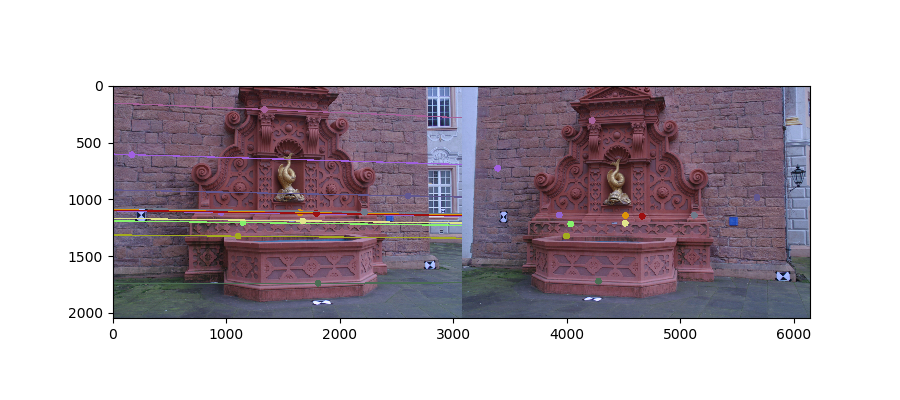

<IPython.core.display.Javascript object>


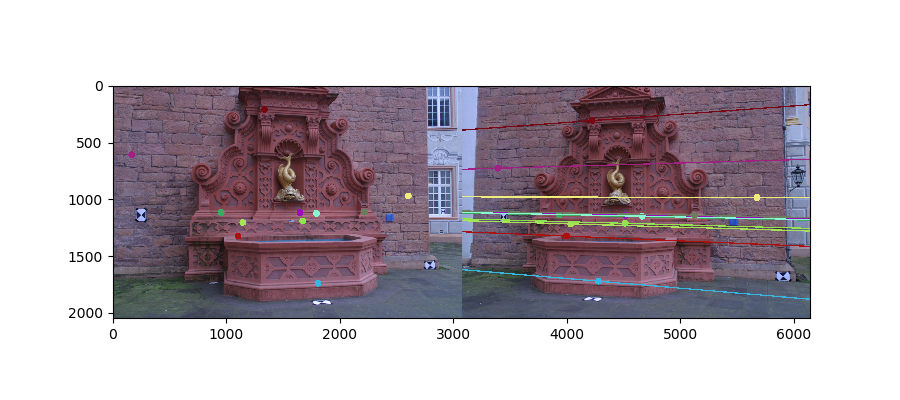

In [11]:
tup = ut.drawlines(img2,img1,lines2,img2pts[mask],img1pts[mask],drawOnly=10,
                   linesize=10,circlesize=30)
epilines2 = np.concatenate(tup,axis=1)

plt.figure(figsize=(9,4))
plt.imshow(epilines2)

tup = ut.drawlines(img1,img2,lines1,img1pts[mask],img2pts[mask],drawOnly=10,
                   linesize=10,circlesize=30)
epilines1 = np.concatenate((tup[1],tup[0]),axis=1) #reversing the order of left and right images

plt.figure(figsize=(9,4))
plt.imshow(epilines1)

### 1.4.2. Epipoles

In [12]:
# to do later..

## 1.5. Pose Estimation

In [13]:
K = np.array([[2759.48,0,1520.69],[0,2764.16,1006.81],[0,0,1]])
E = K.T.dot(F.dot(K))

R1,R2,t = sfmnp.ExtractCameraPoses(E)
t = t[:,np.newaxis]

## 1.6. Visualizations II: Camera Poses

<IPython.core.display.Javascript object>


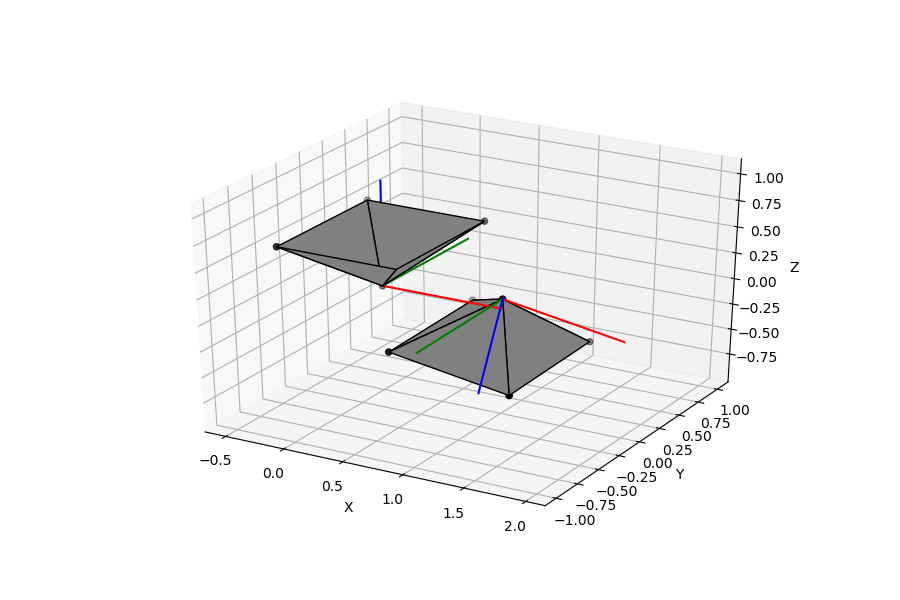

In [14]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax)
ut.PlotCamera(R1,t[:,0],ax)

<IPython.core.display.Javascript object>


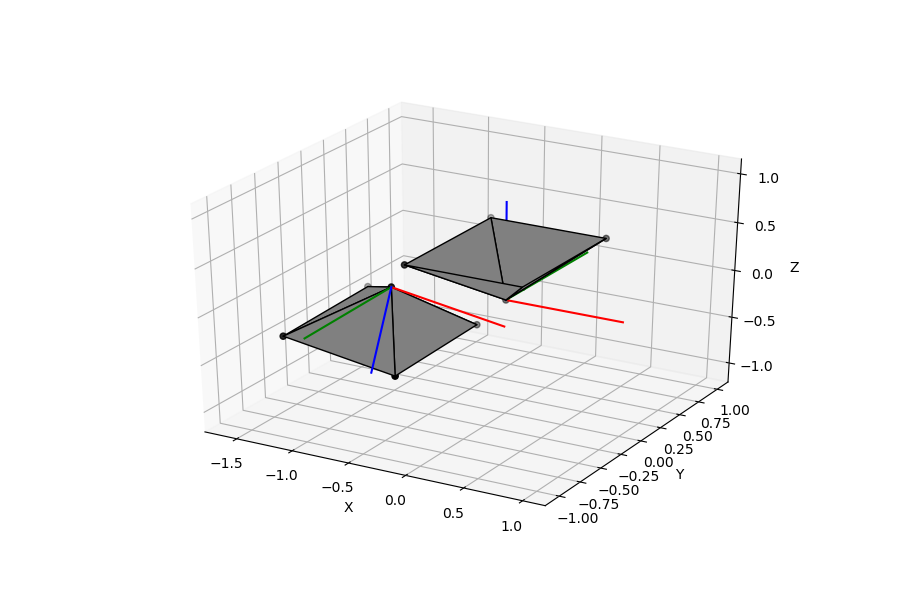

In [15]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax)
ut.PlotCamera(R1,-t[:,0],ax)

<IPython.core.display.Javascript object>


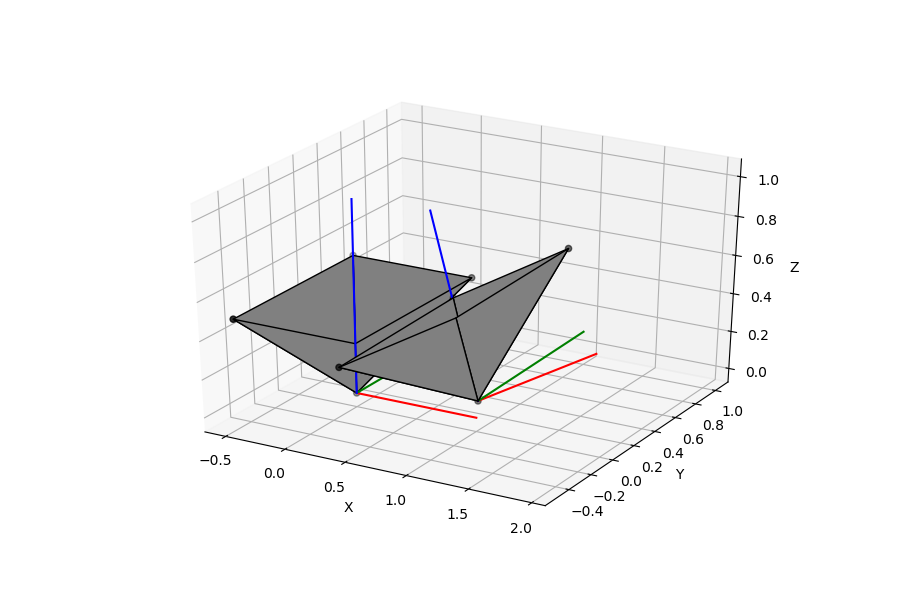

In [16]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax)
ut.PlotCamera(R2,t[:,0],ax)

<IPython.core.display.Javascript object>


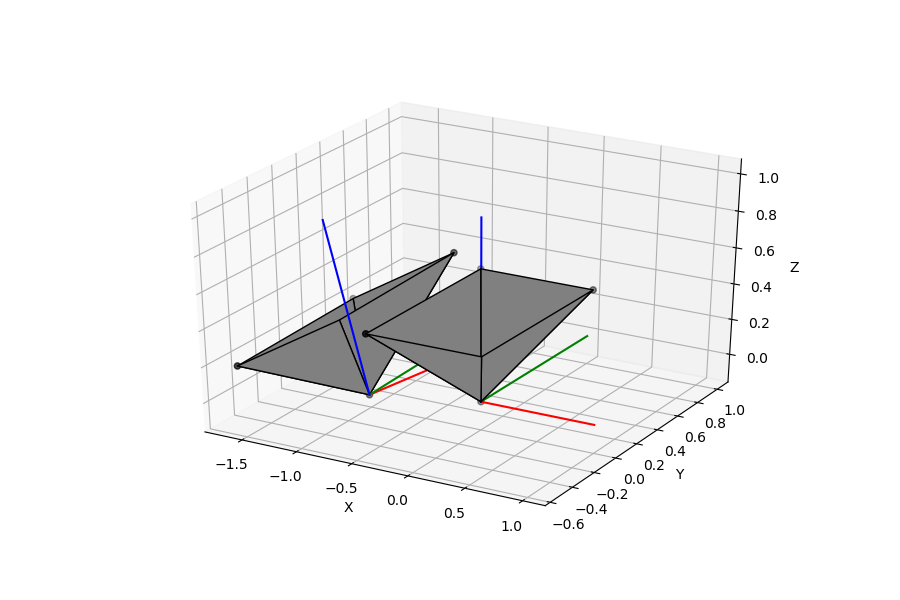

In [17]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax)
ut.PlotCamera(R2,-t[:,0],ax)

# 2. Triangulation

## 2.1. DLT Method 

In [18]:
def GetTriangulatedPts(img1pts,img2pts,K,R,t,triangulateFunc): 
    img1ptsHom = cv2.convertPointsToHomogeneous(img1pts)[:,0,:]
    img2ptsHom = cv2.convertPointsToHomogeneous(img2pts)[:,0,:]

    img1ptsNorm = (np.linalg.inv(K).dot(img1ptsHom.T)).T
    img2ptsNorm = (np.linalg.inv(K).dot(img2ptsHom.T)).T

    img1ptsNorm = cv2.convertPointsFromHomogeneous(img1ptsNorm)[:,0,:]
    img2ptsNorm = cv2.convertPointsFromHomogeneous(img2ptsNorm)[:,0,:]
    
    pts4d = triangulateFunc(np.eye(3,4),np.hstack((R,t)),img1ptsNorm.T,img2ptsNorm.T)
    pts3d = cv2.convertPointsFromHomogeneous(pts4d.T)[:,0,:]
    
    return pts3d

In [19]:
pts3dgt = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t,cv2.triangulatePoints)
pts3d = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t,sfmnp.Triangulate)

In [20]:
print pts3dgt[:5]
print 
print pts3d[:5]
np.testing.assert_allclose(pts3d,pts3dgt,rtol=1e-7,atol=1e-2)

[[-0.90059303  0.01307563 -2.30912247]
 [ 0.06810047 -0.1163391  -2.29631505]
 [ 0.31985885  0.58992528 -2.35701639]
 [ 0.59084492 -0.12132988 -2.45357731]
 [ 0.4719728  -0.18015326 -2.31130289]]

[[-0.90057801  0.01307538 -2.30909305]
 [ 0.0681019  -0.11633975 -2.29631621]
 [ 0.31983572  0.58998544 -2.35721752]
 [ 0.59084485 -0.12132118 -2.45353164]
 [ 0.47197592 -0.18014085 -2.31125598]]


In [21]:
configSet = [None,None,None,None]
configSet[0] = (R1,t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R1,t,sfmnp.Triangulate))
configSet[1] = (R1,-t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R1,-t,sfmnp.Triangulate))
configSet[2] = (R2,t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t,sfmnp.Triangulate))
configSet[3] = (R2,-t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,-t,sfmnp.Triangulate))

## 2.2. Visualizing the triangulated points of configurations

<IPython.core.display.Javascript object>


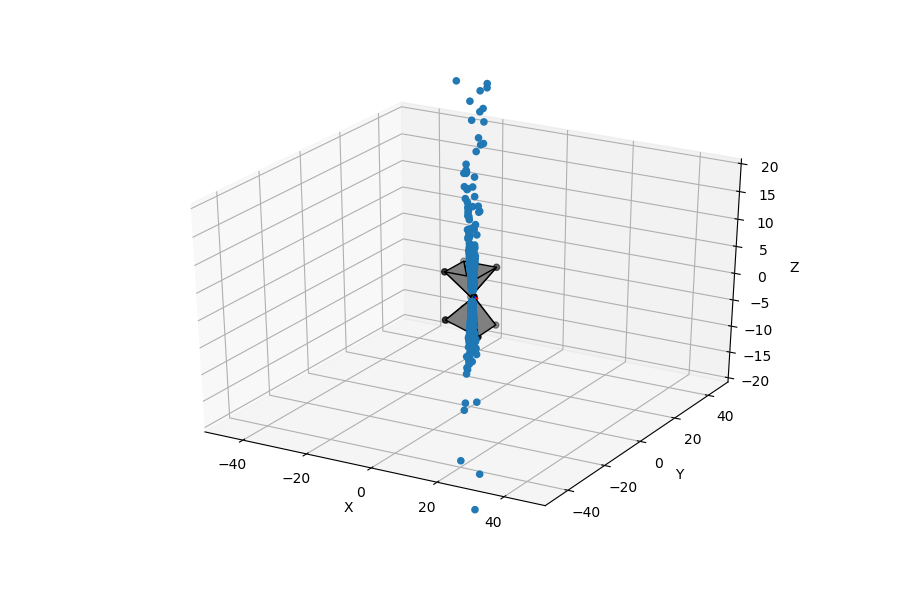

<IPython.core.display.Javascript object>


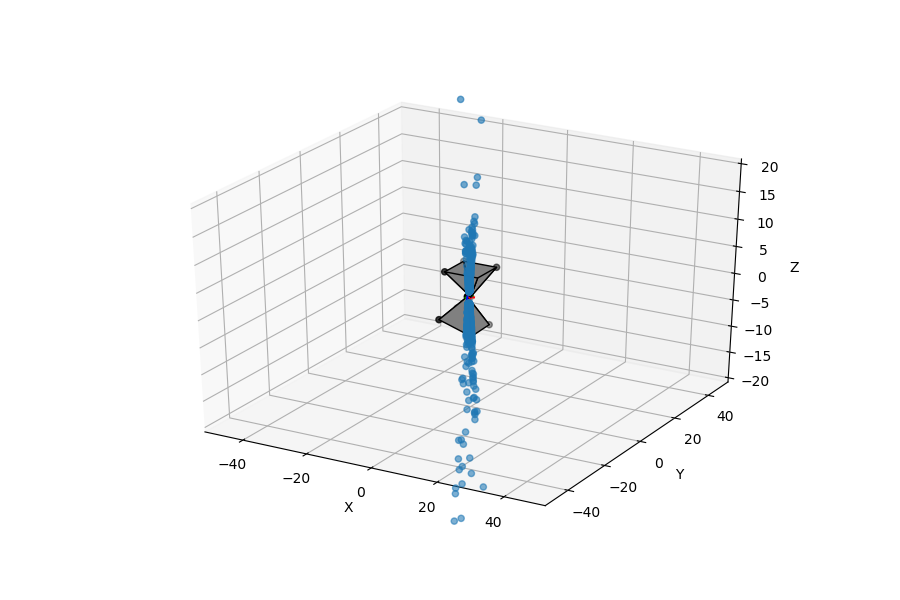

<IPython.core.display.Javascript object>


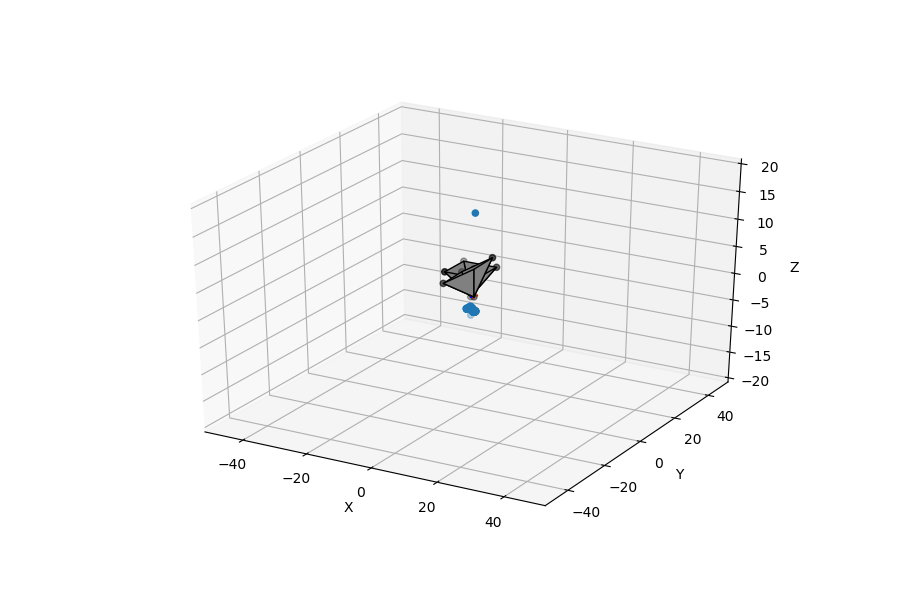

<IPython.core.display.Javascript object>


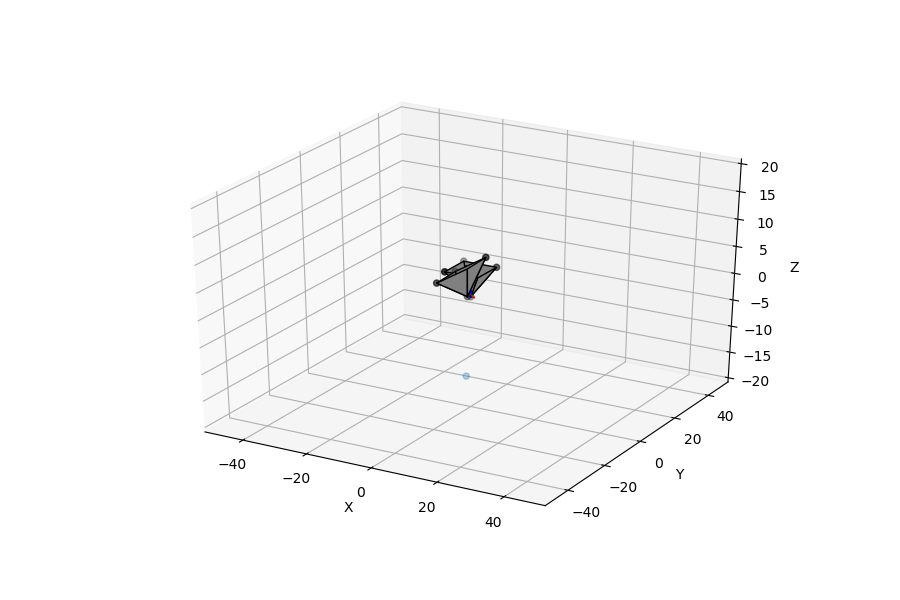

In [22]:
for cs in configSet: 
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax,scale=5,depth=5)
    ut.PlotCamera(cs[0],cs[1][:,0],ax,scale=5,depth=5)

    pts3d = cs[-1]
    ax.scatter3D(pts3d[:,0],pts3d[:,1],pts3d[:,2])

    ax.set_xlim(left=-50,right=50)
    ax.set_ylim(bottom=-50,top=50)
    ax.set_zlim(bottom=-20,top=20)


## 2.3. Camera Pose Disambiguation

In [23]:
_,Rgt,tgt,mask2=cv2.recoverPose(E,img1pts[mask],img2pts[mask],K)
R,t,count = sfmnp.DisambiguateCameraPose(configSet)

In [24]:
print R
print 
print Rgt
print 
print t
print 
print tgt 

np.testing.assert_allclose(R,Rgt,rtol=1e-7,atol=1e-4)
np.testing.assert_allclose(t,tgt,rtol=1e-7,atol=1e-4)

[[ 0.93202391 -0.01521429 -0.36207727]
 [ 0.0088886   0.99977749 -0.01912994]
 [ 0.36228776  0.01461121  0.93195177]]

[[ 0.93202391 -0.01521429 -0.36207727]
 [ 0.0088886   0.99977749 -0.01912994]
 [ 0.36228776  0.01461121  0.93195177]]

[[ 0.99646209]
 [ 0.01851132]
 [ 0.08197953]]

[[ 0.99646209]
 [ 0.01851132]
 [ 0.08197953]]


# 3. Visualizing Point Cloud Output

Since point cloud isn't effectively viewed in matplotlib, we can use an external software `meshlab` for better visualizations. For that, we'd need to transform our 3D points' format into meshlab-compatible format. We understand it can be rather tedious, so the function `pts2ply()` is already implemented for you.

In [25]:
ut.pts2ply(configSet[-1][-1],'out.ply')

Now, please run `out.ply` with `meshlab` like so: `meshlab out.ply`, output is also displayed below for reference

**NOTE**: Meshlab can be installed using

`sudo apt-get install meshlab`

<img src="fountain.png">